Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  lc (0)


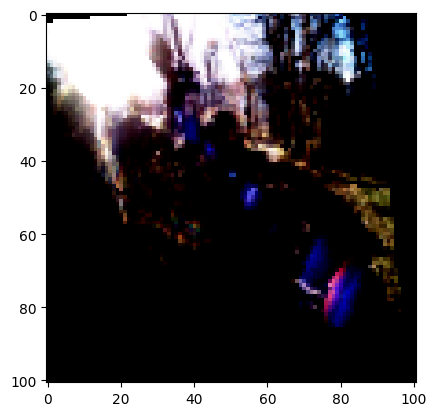

In [32]:
import os
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from random import randrange
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = './dataset'

classes = os.listdir(data_dir + "/train")

dataset = ImageFolder(data_dir+'/train', transform = transforms.Compose([
    transforms.Resize((101,101)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomAffine(translate=(0.1, 0.1), degrees=(-15, 15), scale=(0.9, 0.9))
]))

img, label = dataset[0]



matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[0])   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


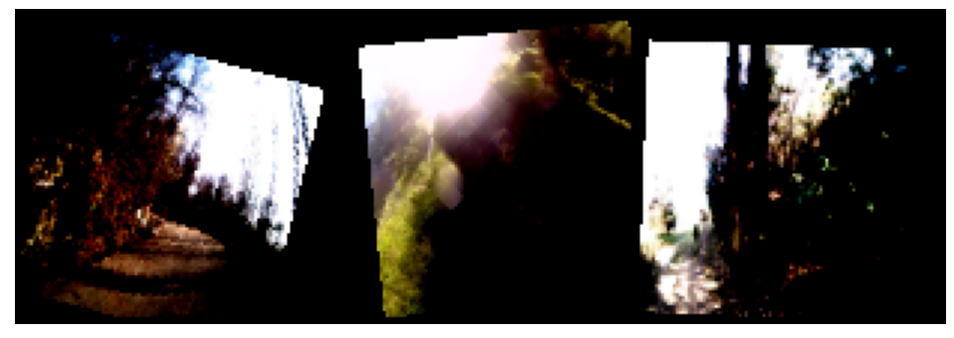

In [33]:
val_size = round(len(dataset) * 0.1)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size=3

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8 , pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=8, pin_memory=True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [34]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
class PerceptionOfForestTrailsForMobileRobots(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # Layer 0: Input Layer
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, padding=0),
            nn.Tanh(),

            # Layer 1: Convolutional Layer
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=0),
            nn.Tanh(),

            # Layer 2: MaxPooling Layer
            nn.MaxPool2d(kernel_size=2),

            # Layer 3: Convolutional Layer
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=0),
            nn.Tanh(),

            # Layer 4: MaxPooling Layer
            nn.MaxPool2d(kernel_size=2),

            # Layer 5: Convolutional Layer
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=0),
            nn.Tanh(),

            # Layer 6: MaxPooling Layer
            nn.MaxPool2d(kernel_size=2),

            # Layer 7: Convolutional Layer
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=0),
            nn.Tanh(),

            # Layer 8: MaxPooling Layer
            nn.MaxPool2d(kernel_size=2), #32 * 3 * 3

            # Layer 9: Fully Connected Layer
            nn.Flatten(),
            nn.Linear(32 * 3 * 3, 200),
            nn.Tanh(),

            # Layer 10: Output Layer
            nn.Linear(200, 3),
            nn.Softmax(dim=1)
            )
        
    def forward(self, xb):
        return self.network(xb)
    
# Initialize model weights with random numbers in the range [-0.05, 0.05]
def initialize_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module.weight.data.uniform_(-0.05, 0.05)
        if module.bias is not None:
            module.bias.data.zero_()

model = PerceptionOfForestTrailsForMobileRobots()
model.apply(initialize_weights)
model

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([3, 3, 101, 101])
out.shape: torch.Size([3, 3])
out[0]: tensor([0.3330, 0.3340, 0.3331], grad_fn=<SelectBackward0>)


In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

PerceptionOfForestTrailsForMobileRobots(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (6): Tanh()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (9): Tanh()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (12): Tanh()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=288, out_features=200, bias=True)
    (16): Tanh()
    (17): Linear(in_features=200, out_features=3, bias=True)
    (18): Softmax(dim=1)
  )
)

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0) #no momentum in paper
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    for epoch in range(epochs):
        print("learning_rate: ", scheduler.get_last_lr())

        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Learning rate scheduler
        scheduler.step()

    return history

In [40]:
model = to_device(PerceptionOfForestTrailsForMobileRobots(), device)

In [41]:
evaluate(model, val_dl)

{'val_loss': 1.0982768535614014, 'val_acc': 0.3418486416339874}

In [42]:
num_epochs = 90
lr = 0.005
history = fit(num_epochs, lr, model, train_dl, val_dl)

learning_rate:  [0.005]
Epoch [0], train_loss: 0.9501, val_loss: 0.8535, val_acc: 0.6955
learning_rate:  [0.00475]
Epoch [1], train_loss: 0.7812, val_loss: 0.7205, val_acc: 0.8261
learning_rate:  [0.0045125]
Epoch [2], train_loss: 0.7145, val_loss: 0.6957, val_acc: 0.8537
learning_rate:  [0.004286875]
Epoch [3], train_loss: 0.6861, val_loss: 0.6832, val_acc: 0.8671
learning_rate:  [0.00407253125]
Epoch [4], train_loss: 0.6715, val_loss: 0.6570, val_acc: 0.8919
learning_rate:  [0.0038689046874999995]
Epoch [5], train_loss: 0.6601, val_loss: 0.6766, val_acc: 0.8720
learning_rate:  [0.003675459453124999]
Epoch [6], train_loss: 0.6519, val_loss: 0.6495, val_acc: 0.8988
learning_rate:  [0.003491686480468749]
Epoch [7], train_loss: 0.6443, val_loss: 0.6435, val_acc: 0.9061
learning_rate:  [0.0033171021564453113]
Epoch [8], train_loss: 0.6390, val_loss: 0.6308, val_acc: 0.9191
learning_rate:  [0.0031512470486230455]
Epoch [9], train_loss: 0.6373, val_loss: 0.6405, val_acc: 0.9106
learning_rat

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

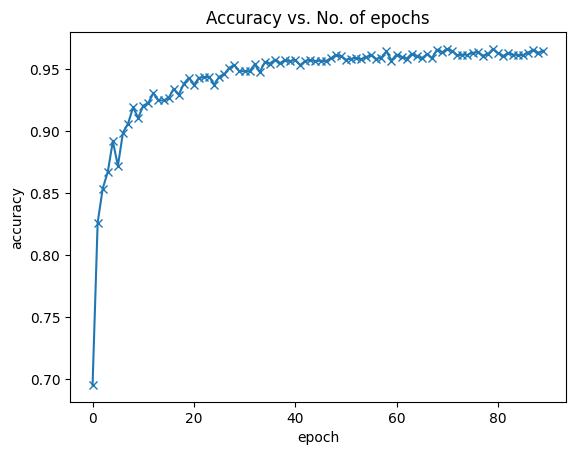

In [44]:
plot_accuracies(history)

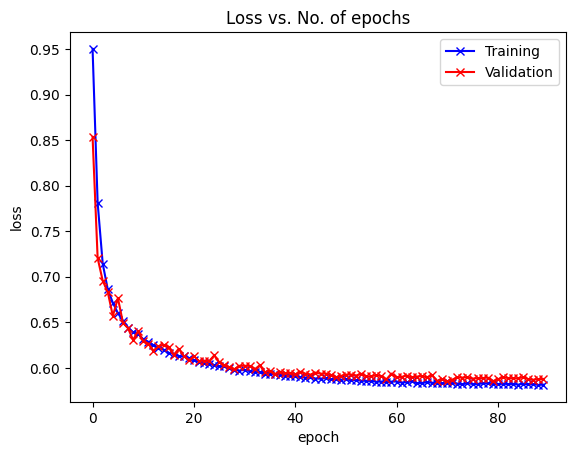

In [45]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

In [46]:
test_dataset = ImageFolder(data_dir+'/test', transform= transforms.Compose([
    transforms.Resize((101,101)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]))

test_dl = DataLoader(test_dataset, batch_size, num_workers=8, pin_memory=True)
test_dl = DeviceDataLoader(train_dl, device)

In [47]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: rc , Predicted: rc


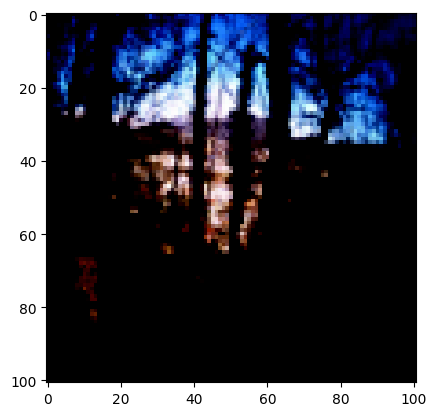

In [48]:
img, label = test_dataset[randrange(len(test_dataset))]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [49]:
print("train", evaluate(model, train_dl))
print("val",evaluate(model, val_dl))
print("test",evaluate(model, test_dl))

torch.save(model.state_dict(), 'weights_and_biases.pth')

train {'val_loss': 0.581527829170227, 'val_acc': 0.970411479473114}
val {'val_loss': 0.5883225798606873, 'val_acc': 0.9627797603607178}
test {'val_loss': 0.5817604064941406, 'val_acc': 0.9697551727294922}
